In [1]:
import numpy as np

## Note to self
- **Population size**
    - Tune it to get optimal value
- **Mutation**
    - have a mutation rate of 10% to 30%. 
    - have a maximum delta for mutation change. So that weights are not changed drastically.
- **Crossover** 
    - have to use one/many from Single/two point crossover or Uniform crossover.
    - to generate new offspring/chromosome using two parent chromosome
- **Balance factor**
    - Give very preference to crossover or mutation depending on application.
        - In Neural Network optimization I would try to give low preference to cross over
- **Application**
    - Neural network weights optimisation. 
    - I am , here, not concerned about other parameters like number of layers/ number of neurons per layers. Which I would ideally hardcore
    

In [2]:
# Initialize genes(w) and population 
# neural network with 1 layer and 2 neurons
def initlize_population(pop_size=10, n_params=3):
    population = np.random.normal(0,0.1, size=(pop_size, n_params))
    return population

# Perform mutation with a mutation rate
def perform_mutation(chromosome, mutation_rate=0.5):
    for i in range(len(chromosome)):
        # To apply mutation rate
        if np.random.rand() < mutation_rate:
            # To randomly increase and decrease weight - normal distribution with mean=0, std=0.1
            chromosome[i] += np.random.normal(0,0.2)
    return np.array(chromosome)

# Perform cross over operation (often rarely)
# Here parent1 and parent2 are chromosomes
def perform_crossover(parent1, parent2):
    # 1-point cross over performed 
    pt0 = np.random.randint(0, len(parent1) - 1)
    child1 = np.concatenate((parent1[:pt0], parent2[pt0:]))
    child2 = np.concatenate((parent2[:pt0], parent1[pt0:]))
    
    # 2-point cross over
    pt1 = np.random.randint(0, len(parent1) - 1)
    pt2 = np.random.randint(0, len(parent1) - 1)
    if pt2 < pt1:
        pt1, pt2 = pt2, pt1
    
    child3 = np.concatenate((parent1[:pt1], parent2[pt1:pt2], parent1[pt2:]))
    return child1.reshape(1,-1), child2.reshape(1,-1), child3.reshape(1,-1)

# Assigning genetically calculated weights to neural network layers
# First two genes are weights and bias of neuron 1
def assign_weights(best_chromosome, model):
    input_nodes = 1
    hidden_nodes = 2
    output_nodes = 1
    
    # Vector of length = 4(2 weight + 2 bias) + 3 (2 weight + 1 bias) = 7
    weights = best_chromosome
    # reshaping for input layer's weights and bias
    input_layer_weights = weights[:input_nodes * hidden_nodes].reshape(hidden_nodes, input_nodes)
    used = input_nodes * hidden_nodes
    input_layer_bias = weights[used : used + hidden_nodes].reshape(hidden_nodes, 1)
    used += hidden_nodes    
    
    # reshaping for output layer's weights and bias
    weights = weights[used:].copy()
    output_layer_weights = weights[: hidden_nodes * output_nodes].reshape(output_nodes, hidden_nodes)
    used = hidden_nodes * output_nodes
    output_layer_bias = weights[used : ].reshape(1,1)
    
    model.W1 = input_layer_weights
    model.B1 = input_layer_bias
    model.W2 = output_layer_weights
    model.B2 = output_layer_bias
    
    return model


# Mean squared error --> lower is better
def loss_fn(pred, target):
    mse = np.mean((pred - target)**2)
    return mse
    
# Fitness function - evaluate fitness of each chromosome in population 
def evaluate_fitness(model, population, X, y):
    all_loss = []
    for chromosome in population:
        model = assign_weights(chromosome, model)
        pred = model.predict(X)
        loss = loss_fn(pred, y)
        all_loss.append(loss)
    return np.array(all_loss)    

# Roulette wheel based selection of population for next generation. Size=k    
def perform_selection(new_population, model, X, y, k=10):
    fitness = evaluate_fitness(model, new_population, X, y)
    fitness = fitness.reshape(-1)
    # sorting from lowest to highest
    sorted_fitness_index = np.argsort(fitness)
    fitness = fitness[sorted_fitness_index]
    new_population = new_population[sorted_fitness_index, :]
    
    # Roulette wheel selection
    prob = fitness/np.sum(fitness)
    cum_probs = np.cumsum(prob)
    selected_index = []
    for i in range(k):
        r = np.random.rand()
        index = np.where(cum_probs > r)[0][0]
        
        # Inverse index to give more priority to least values
        index = len(fitness) - 1 - index
        selected_index.append(index)
    
    selected_index = np.array(selected_index)
    
    # Selecting the corresponding population and loss for those index
    selected_population = new_population[selected_index, :]
    k_losses = fitness[selected_index]
    
    return selected_population, k_losses

def GeneticAlgorithm(model, pop, X, y, crossover_rate, mutation_rate, k):
    # Mutation
    for j in range(len(pop)):
        pop[j] = perform_mutation(pop[j], mutation_rate)
    # Crossover
    times = np.random.randint(1,5)
    if np.random.rand() < crossover_rate:
        for _ in range(times):
            p1, p2 = np.random.choice(len(pop), 2)
            child1, child2, child3 = perform_crossover(pop[p1], pop[p2])
            pop = np.concatenate([pop, child1, child2, child3], axis=0)
    # Selection
    pop, losses = perform_selection(pop, model, X, y, k)
    
    return pop, losses
    
    

## Model and train loop
- Need not to define model as class or train loop in this way.
- I just want to make it consistent with my usual PyTorch implementations so that I can relate it easily

In [3]:
class Net():
    def __init__(self, in_features=1, out_features=1):
        self.W1 = np.random.rand(2,in_features)
        self.B1 = np.random.rand(2,1)
        self.W2 = np.random.rand(1,2)
        self.B2 = np.random.rand(out_features,1)
    def forward(self, X):
        output = self.W1 @ X + self.B1
        output = self.W2 @ output + self.B2
        return output
    def predict(self, X):
        return self.forward(X)
model = Net()

In [4]:
## Toy data

X = np.arange(10).reshape(10,1)
X_Norm = (X - X.mean())/ X.std()


Y = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0])

X_Norm = X_Norm.T
Y = Y.T

In [5]:
def train(model, pop, generation, X, y, crossover_rate=0.5, mutation_rate=0.5, k=10):
    losses_generation = []
    losses = None
    for i in range(generation):
        
        # Genetic Algorithm
        pop, losses = GeneticAlgorithm(model, pop,X, y, crossover_rate, mutation_rate, k)
        
        # Displaying loss at each generation
        print(min(losses))
        final_loss = min(losses)
        losses_generation.append(min(losses))
        
    return losses_generation, pop, losses
        

In [6]:
pop = initlize_population(100,7)
losses, pop, final_loss = train(
    model,pop, 100, X_Norm, Y, crossover_rate=0.5, mutation_rate=1, k=40
)

27.236903584232728
24.25893396708448
19.089776090567234
20.92685151814306
20.06023751728494
14.656967044754008
12.024063918485655
12.59275950964213
8.196578706222857
11.19866804443804
9.239198562011747
10.179517547086725
13.1992469179663
11.40497581991529
6.6577724296737015
3.347946696114259
2.3251258054340496
2.3591546252473785
1.269349430185874
1.0926570294685547
0.45082387951130815
0.4110482706069285
0.43781710302791293
0.4379058576579906
0.4238573301782198
0.47137834390211164
0.5391115771128385
0.4040591859404006
0.4073164231477017
0.40589498377595506
0.41073631039611247
0.4209898397532763
0.4241368920684163
0.4028049818310726
0.43831437035909093
0.4324254478373074
0.5587217733206
0.42322623760749656
0.4503387496934293
0.4899937628260962
0.4451970625433629
0.4396980060784143
0.42325874875474145
0.41019415524238323
0.4168177831200851
0.4340770096266418
0.4583233224023183
0.4161071988977386
0.4036945784995967
0.47836300034650997
0.503312119807305
0.40558747292152886
0.430060249742811

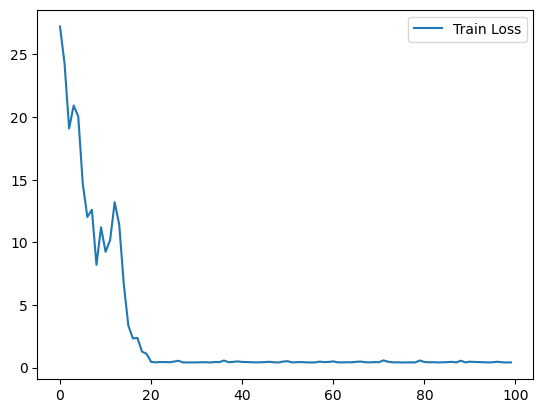

In [7]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.legend(['Train Loss'])

### Remarks
- seems like it struct to local optima !

In [8]:
## Best weights
index = np.argsort(final_loss)[0]
weights = pop[index, :]
model = assign_weights(weights, model)

In [9]:
final_loss[index]

0.4119556556079892

## Visualize regression line

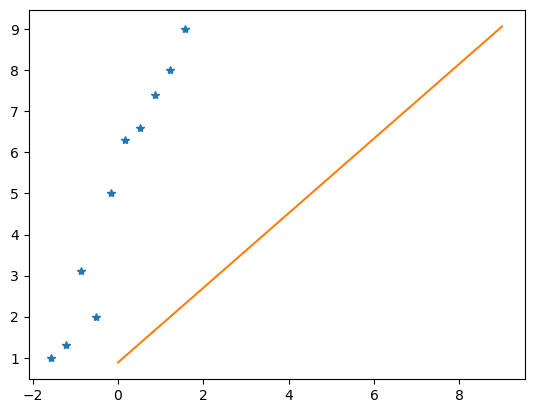

In [10]:
plt.plot(X_Norm.reshape(-1), Y, linestyle="", marker='*')
plt.plot(np.arange(10), model.predict(X_Norm).reshape(-1))

#### Not an impressive line of best fit